## Use this starter notebook to run some new experiments

In [1]:
# Change path as needed
MAP_PATH = "../tests/pickle_data/GresvanAIE.xz"

In [2]:
# load cell magic things
%load_ext line_profiler
%load_ext Cython

In [9]:
# imports
import matplotlib.pyplot as plt
import numpy as np

from sc2.ids.ability_id import AbilityId
from sc2.ids.unit_typeid import UnitTypeId
from sc2.bot_ai import BotAI
from sc2.position import Point2
from sc2.dicts.unit_trained_from import UNIT_TRAINED_FROM
from sc2.game_data import Race
from sc2.unit import Unit
from sc2.units import Units
from sc2.constants import CREATION_ABILITY_FIX
from collections import Counter

from tests.load_bot_from_pickle import get_map_specific_bot

In [10]:
# setup a burnysc2 BOTAI instance we can test with
bot: BotAI = get_map_specific_bot(MAP_PATH)

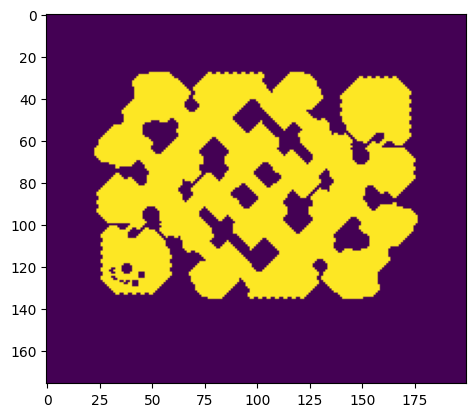

In [11]:
# sanity check that the bot instance is working
plt.imshow(bot.game_info.pathing_grid.data_numpy)

In [26]:
%%cython
# cython: boundscheck=False, wraparound=False, cdivision=True
cimport cython



cdef int MAX_KEY = 4200
cdef int mapping_array[4200]

# only set the ones you need
mapping_array[18] = 318 #CommandCenter
mapping_array[19] = 319 #SupplyDepot
mapping_array[20] = 320 #Refinery
mapping_array[21] = 321 #Barracks
mapping_array[22] = 322 #EngineeringBay
mapping_array[23] = 323 #missileTurret
mapping_array[24] = 324 #Bunker


mapping_array[25] = 326 #SensorTower
mapping_array[26] = 327 #GhostAcademy
mapping_array[27] = 328 #Factory
mapping_array[28] = 329 #Starport

mapping_array[29] = 331 #Armory
mapping_array[30] = 333 #FusionCore

mapping_array[37] = 421 #TechLab Barracks
mapping_array[38] = 422 #Reactor Barracks
mapping_array[39] = 454 #TechLab Factory
mapping_array[40] = 455 #Reactor Factory
mapping_array[41] = 487 #TechLab Starport
mapping_array[42] = 488 #Reactor Starport

mapping_array[130] = 1450 #PlanetaryFortress
mapping_array[132] = 1516 #OrbitalCommand

mapping_array[59] = 880 #Nexus
mapping_array[60] = 881 #Pylon
mapping_array[61] = 882 #Assimilator
mapping_array[62] = 883 #Gateway
mapping_array[63] = 884 #Forge
mapping_array[64] = 885 #FleetBeacon
mapping_array[65] = 886 #TwilightCouncil
mapping_array[66] = 887 #PhotonCannon
mapping_array[67] = 889 #Stargate
mapping_array[68] = 890 #TemplarArchive
mapping_array[69] = 891 #DarkShrine
mapping_array[70] = 892 #RoboticsBay
mapping_array[71] = 893 #RoboticsFacility
mapping_array[72] = 894 #CyberneticsCore
mapping_array[1910] = 895 #ShieldBattery




mapping_array[86] = 1152 #Hatchery
mapping_array[87] = 1153 #CreepTumor
mapping_array[88] = 1154 #Extractor
mapping_array[89] = 1155 #SpawningPool
mapping_array[90] = 1156 #EvolutionChamber
mapping_array[91] = 1157 #HydraliskDen
mapping_array[92] = 1158 #Spire
mapping_array[93] = 1159 #UltraliskCavern
mapping_array[94] = 1160 #InfestationPit
mapping_array[95] = 1161 #NydusNetwork
mapping_array[96] = 1162 #BanelingNest

mapping_array[97] = 1165 #RoachWarren
mapping_array[98] = 1166 #SpineCrawler
mapping_array[99] = 1167 #SporeCrawler


@cython.cfunc
@cython.inline
cdef int _map_value(int key) nogil:
    if 0 <= key < MAX_KEY:
        return mapping_array[key]
    return -1


def map_value(int key):
    return _map_value(key)

In [14]:
from collections import Counter
from sc2.ids.ability_id import AbilityId
from sc2.ids.unit_typeid import UnitTypeId
from sc2.constants import (
    ALL_GAS,
    CREATION_ABILITY_FIX,
    IS_PLACEHOLDER,
)
def _abilities_count_and_build_progress(self) -> tuple[Counter[AbilityId], dict[AbilityId, float]]:
        """Cache for the already_pending function, includes protoss units warping in,
        all units in production and all structures, and all morphs"""
        abilities_amount: Counter[AbilityId] = Counter()
        unit: Unit
        for unit in self.units + self.structures:
            for order in unit.orders:
                abilities_amount[order.ability.exact_id] += 1
            if not unit.is_ready and (self.race != Race.Terran or not unit.is_structure):
                # If an SCV is constructing a building, already_pending would count this structure twice
                # (once from the SCV order, and once from "not structure.is_ready")
                if unit.type_id in CREATION_ABILITY_FIX:
                    if unit.type_id == UnitTypeId.ARCHON:
                        # Hotfix for archons in morph state
                        creation_ability = AbilityId.ARCHON_WARP_TARGET
                        abilities_amount[creation_ability] += 2
                    else:
                        # Hotfix for rich geysirs
                        creation_ability = CREATION_ABILITY_FIX[unit.type_id]
                        abilities_amount[creation_ability] += 1
                else:
                    creation_ability: AbilityId = self.game_data.units[unit.type_id.value].creation_ability.exact_id
                    abilities_amount[creation_ability] += 1
        return abilities_amount

In [15]:
%timeit _abilities_count_and_build_progress(bot)

19.4 μs ± 259 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [28]:
UNIT_TYPE_ID_TO_ABILITY_MAP = {
    UnitTypeId.COMMANDCENTER: AbilityId.TERRANBUILD_COMMANDCENTER,
    UnitTypeId.SUPPLYDEPOT: AbilityId.TERRANBUILD_SUPPLYDEPOT,
    UnitTypeId.REFINERY: AbilityId.TERRANBUILD_REFINERY,
    UnitTypeId.BARRACKS: AbilityId.TERRANBUILD_BARRACKS,
    UnitTypeId.ENGINEERINGBAY: AbilityId.TERRANBUILD_ENGINEERINGBAY,
    UnitTypeId.MISSILETURRET: AbilityId.TERRANBUILD_MISSILETURRET,
    UnitTypeId.BUNKER: AbilityId.TERRANBUILD_BUNKER,
    UnitTypeId.SENSORTOWER: AbilityId.TERRANBUILD_SENSORTOWER,
    UnitTypeId.GHOSTACADEMY: AbilityId.TERRANBUILD_GHOSTACADEMY,
    UnitTypeId.FACTORY: AbilityId.TERRANBUILD_FACTORY,
    UnitTypeId.STARPORT: AbilityId.TERRANBUILD_STARPORT,
    UnitTypeId.ARMORY: AbilityId.TERRANBUILD_ARMORY,
    UnitTypeId.FUSIONCORE: AbilityId.TERRANBUILD_FUSIONCORE,
    UnitTypeId.BARRACKSTECHLAB: AbilityId.BUILD_TECHLAB_BARRACKS,
    UnitTypeId.FACTORYTECHLAB: AbilityId.BUILD_TECHLAB_FACTORY,
    UnitTypeId.STARPORTTECHLAB: AbilityId.BUILD_TECHLAB_STARPORT,
    UnitTypeId.BARRACKSREACTOR: AbilityId.BUILD_REACTOR_BARRACKS,
    UnitTypeId.FACTORYREACTOR: AbilityId.BUILD_REACTOR_FACTORY,
    UnitTypeId.STARPORTREACTOR: AbilityId.BUILD_REACTOR_STARPORT,
    UnitTypeId.PLANETARYFORTRESS: AbilityId.UPGRADETOPLANETARYFORTRESS_PLANETARYFORTRESS,
    UnitTypeId.ORBITALCOMMAND: AbilityId.UPGRADETOORBITAL_ORBITALCOMMAND,
    UnitTypeId.NEXUS: AbilityId.PROTOSSBUILD_NEXUS,
    UnitTypeId.PYLON: AbilityId.PROTOSSBUILD_PYLON,
    UnitTypeId.ASSIMILATOR: AbilityId.PROTOSSBUILD_ASSIMILATOR,
    UnitTypeId.GATEWAY: AbilityId.PROTOSSBUILD_GATEWAY,
    UnitTypeId.FORGE: AbilityId.PROTOSSBUILD_FORGE,
    UnitTypeId.TWILIGHTCOUNCIL: AbilityId.PROTOSSBUILD_TWILIGHTCOUNCIL,
    UnitTypeId.FLEETBEACON: AbilityId.PROTOSSBUILD_FLEETBEACON,
    UnitTypeId.PHOTONCANNON: AbilityId.PROTOSSBUILD_PHOTONCANNON,
    UnitTypeId.STARGATE: AbilityId.PROTOSSBUILD_STARGATE,
    UnitTypeId.TEMPLARARCHIVE: AbilityId.PROTOSSBUILD_TEMPLARARCHIVE,
    UnitTypeId.DARKSHRINE: AbilityId.PROTOSSBUILD_DARKSHRINE,
    UnitTypeId.ROBOTICSBAY: AbilityId.PROTOSSBUILD_ROBOTICSBAY,
    UnitTypeId.ROBOTICSFACILITY: AbilityId.PROTOSSBUILD_ROBOTICSFACILITY,
    UnitTypeId.CYBERNETICSCORE: AbilityId.PROTOSSBUILD_CYBERNETICSCORE,
    UnitTypeId.SHIELDBATTERY: AbilityId.BUILD_SHIELDBATTERY,
    UnitTypeId.HATCHERY: AbilityId.ZERGBUILD_HATCHERY,
    UnitTypeId.EXTRACTOR: AbilityId.ZERGBUILD_EXTRACTOR,
    UnitTypeId.SPAWNINGPOOL: AbilityId.ZERGBUILD_SPAWNINGPOOL,
    UnitTypeId.EVOLUTIONCHAMBER: AbilityId.ZERGBUILD_EVOLUTIONCHAMBER,
    UnitTypeId.ROACHWARREN: AbilityId.ZERGBUILD_ROACHWARREN,
    UnitTypeId.SPINECRAWLER: AbilityId.ZERGBUILD_SPINECRAWLER,
    UnitTypeId.SPORECRAWLER: AbilityId.ZERGBUILD_SPORECRAWLER,
    UnitTypeId.HYDRALISKDEN: AbilityId.ZERGBUILD_HYDRALISKDEN,
    UnitTypeId.SPIRE: AbilityId.ZERGBUILD_SPIRE,
    UnitTypeId.ULTRALISKCAVERN: AbilityId.ZERGBUILD_ULTRALISKCAVERN,
    UnitTypeId.INFESTATIONPIT: AbilityId.ZERGBUILD_INFESTATIONPIT,
    UnitTypeId.NYDUSNETWORK: AbilityId.ZERGBUILD_NYDUSNETWORK,
    UnitTypeId.BANELINGNEST: AbilityId.ZERGBUILD_BANELINGNEST,
    UnitTypeId.ASSIMILATORRICH: AbilityId.PROTOSSBUILD_ASSIMILATOR,
    UnitTypeId.EXTRACTORRICH: AbilityId.ZERGBUILD_EXTRACTOR,
    UnitTypeId.REFINERYRICH: AbilityId.TERRANBUILD_REFINERY,
}

109 ns ± 1.06 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [33]:
def cache_per_game_loop(func):
    """Decorator to cache a method's result until bot.state.game_loop changes."""
    cache_name = f"_{func.__name__}_cache"
    loop_name = f"_{func.__name__}_loop"

    def wrapper(bot, *args, **kwargs):
        current_loop = bot.state.game_loop
        if getattr(bot, loop_name, object()) == current_loop:
            return getattr(bot, cache_name)
        result = func(bot, *args, **kwargs)
        setattr(bot, cache_name, result)
        setattr(bot, loop_name, current_loop)
        return result
    return wrapper

In [34]:
@cache_per_game_loop
def _abilities_count_structures(bot):
    """Cache for the already_pending function, includes protoss units warping in,
    all units in production and all structures, and all morphs"""
    abilities_amount: Counter[AbilityId] = Counter()

    for worker in bot.workers:
        for order in worker.orders:
            abilities_amount[order.ability.exact_id] += 1
    if bot.race == Race.Terran:
        return abilities_amount

    for structure in bot.structures:
        if structure.build_progress < 1.0:
            # If an SCV is constructing a building, already_pending would count this structure twice
            # (once from the SCV order, and once from "not structure.is_ready")
            type_id = structure.type_id
            if type_id in UNIT_TYPE_ID_TO_ABILITY_MAP:
                creation_ability: AbilityId = UNIT_TYPE_ID_TO_ABILITY_MAP[type_id]
                abilities_amount[creation_ability] += 1

    return abilities_amount

In [35]:
%timeit _abilities_count_structures(bot)

195 ns ± 0.306 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
